In [1]:
import json
import pandas as pd
from urllib.request import urlopen
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [2]:
url = "https://api.worldbank.org/v2/countries/CHN/indicators/NY.GDP.MKTP.CD?per_page=5000&format=json"
response = urlopen(url)
data_json = json.loads(response.read())
if isinstance(data_json, list) and len(data_json) > 1:
    # Normalize the data part (usually the second element in the list)
    df = pd.json_normalize(data_json[1])
else:
    df = pd.DataFrame()  # Fallback to an empty DataFrame if the structure is not as expected

df.head()

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value
0,CHN,2022,1.796317e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China
1,CHN,2021,1.782046e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China
2,CHN,2020,1.468774e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China
3,CHN,2019,1.427997e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China
4,CHN,2018,1.389491e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China


In [3]:
#Transformed number into trillion for easier visualization
df['value_billions'] = df['value'] / 1e9
df.head()

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,value_billions
0,CHN,2022,1.796317e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,17963.170521
1,CHN,2021,1.782046e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,17820.459342
2,CHN,2020,1.468774e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,14687.743557
3,CHN,2019,1.427997e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,14279.968486
4,CHN,2018,1.389491e+13,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,13894.907485


In [4]:
df.describe(include='all')

,countryiso3code,date,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,value_billions
count,63,63,6.300000e+01,63,63,63.0,63,63,63,63,63.000000
unique,1,63,NaN,1,1,NaN,1,1,1,1,NaN
top,CHN,2022,NaN,,,NaN,NY.GDP.MKTP.CD,GDP (current US$),CN,China,NaN
freq,63,1,NaN,63,63,NaN,63,63,63,63,NaN
mean,NaN,NaN,3.062319e+12,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3062.319399
std,NaN,NaN,4.953679e+12,NaN,NaN,0.0,NaN,NaN,NaN,NaN,4953.678954
min,NaN,NaN,4.720919e+10,NaN,NaN,0.0,NaN,NaN,NaN,NaN,47.209188
25%,NaN,NaN,1.517400e+11,NaN,NaN,0.0,NaN,NaN,NaN,NaN,151.739995
50%,NaN,NaN,3.833733e+11,NaN,NaN,0.0,NaN,NaN,NaN,NaN,383.373318
75%,NaN,NaN,3.151223e+12,NaN,NaN,0.0,NaN,NaN,NaN,NaN,3151.223056


In [5]:
# Print the column names of the DataFrame
print(df.columns)

Index(['countryiso3code', 'date', 'value', 'unit', 'obs_status', 'decimal',
       'indicator.id', 'indicator.value', 'country.id', 'country.value',
       'value_billions'],
      dtype='object')


In [6]:
descriptive_stats = df['value'].describe()
print(descriptive_stats)

count    6.300000e+01
mean     3.062319e+12
std      4.953679e+12
min      4.720919e+10
25%      1.517400e+11
50%      3.833733e+11
75%      3.151223e+12
max      1.796317e+13
Name: value, dtype: float64


In [7]:
df.isnull().any().sum()

0

In [8]:
# Convert 'date' to a datetime object and then extract the year as an integer
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.year


# Define the time periods (for example, before and after the year 2000)
split_year = 2000
before_2000 = df[df['date'] < split_year]['value'].dropna()
after_2000 = df[df['date'] >= split_year]['value'].dropna()

# Check if the subsets are populated
print("Number of entries before 2000:", before_2000.size)
print("Number of entries after 2000:", after_2000.size)

# Perform the independent samples t-test, if both subsets are non-empty
if not before_2000.empty and not after_2000.empty:
    t_test_result = stats.ttest_ind(before_2000, after_2000)
    print("T-Test Result:", t_test_result)
else:
    print("One or both subsets are empty, t-test cannot be performed")


Number of entries before 2000: 40
Number of entries after 2000: 23
T-Test Result: Ttest_indResult(statistic=-8.706969262130112, pvalue=2.6986241889477673e-12)


In the analysis, an independent samples t-test was conducted to compare the mean GDP values of China between two distinct time periods: before and after the year 2000. This test helps determine whether there is a statistically significant difference in China's average GDP between these two eras. The t-test yielded a statistic of -8.706969262130116 and a p-value of approximately 2.70e-12. The negative test statistic indicates that the mean GDP in the period before 2000 was lower than the mean GDP after 2000. The extremely small p-value, much lower than the conventional alpha level of 0.05, suggests that this difference in means is statistically significant. In terms of hypothesis testing, the null hypothesis (that there is no difference in mean GDP between the two periods) is rejected, indicating a significant change in China's GDP around the year 2000. This result could reflect substantial economic shifts or policy changes around the turn of the millennium, warranting further investigation into the contextual factors influencing these economic trends.


The Shapiro-Wilk test is a statistical procedure used to assess whether a dataset is normally distributed. It compares the distribution of the data against the normal distribution by calculating a W statistic, which indicates how much the data deviates from normality. This test was chosen because it's particularly effective for small to moderate-sized datasets, offering high sensitivity to deviations from a normal distribution. 

In [9]:
# Perform the Shapiro-Wilk test for normality
# Ensure that you have no NaN values in the 'value' column
shapiro_test = stats.shapiro(df['value'].dropna())

# The Shapiro-Wilk test returns a tuple of the test statistic and the p-value
shapiro_stat, shapiro_p_value = shapiro_test

print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}, P-Value: {shapiro_p_value}")

# Interpretation of the test
if shapiro_p_value > 0.05:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")


Shapiro-Wilk Test Statistic: 0.6551258563995361, P-Value: 6.807249902651691e-11
The data does not follow a normal distribution (reject H0).


To prove info above:

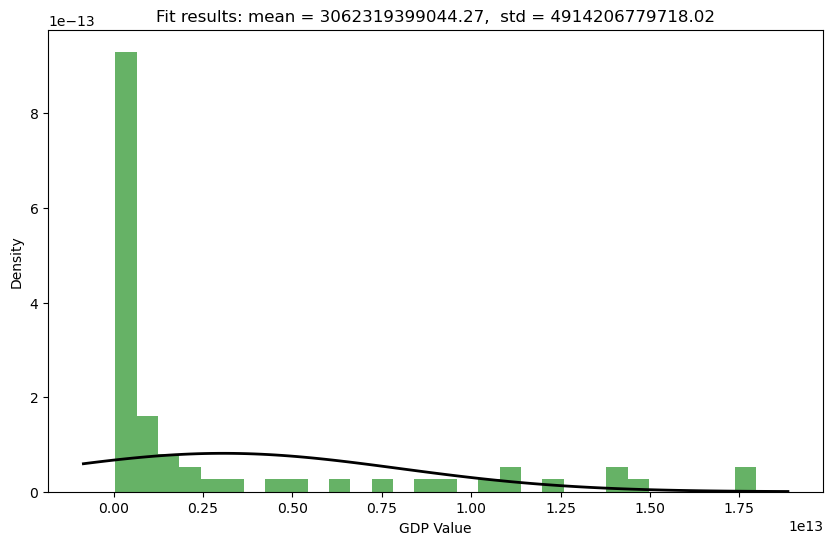

In [10]:
# Drop NaN values from the 'value' column for accurate representation
data = df['value'].dropna()

# Calculate mean and standard deviation of the data
mean = np.mean(data)
std = np.std(data)

# Plot the histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Plot the normal distribution with the same mean and standard deviation
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mean = %.2f,  std = %.2f" % (mean, std)
plt.title(title)
plt.xlabel('GDP Value')
plt.ylabel('Density')

# Show the plot
plt.show()

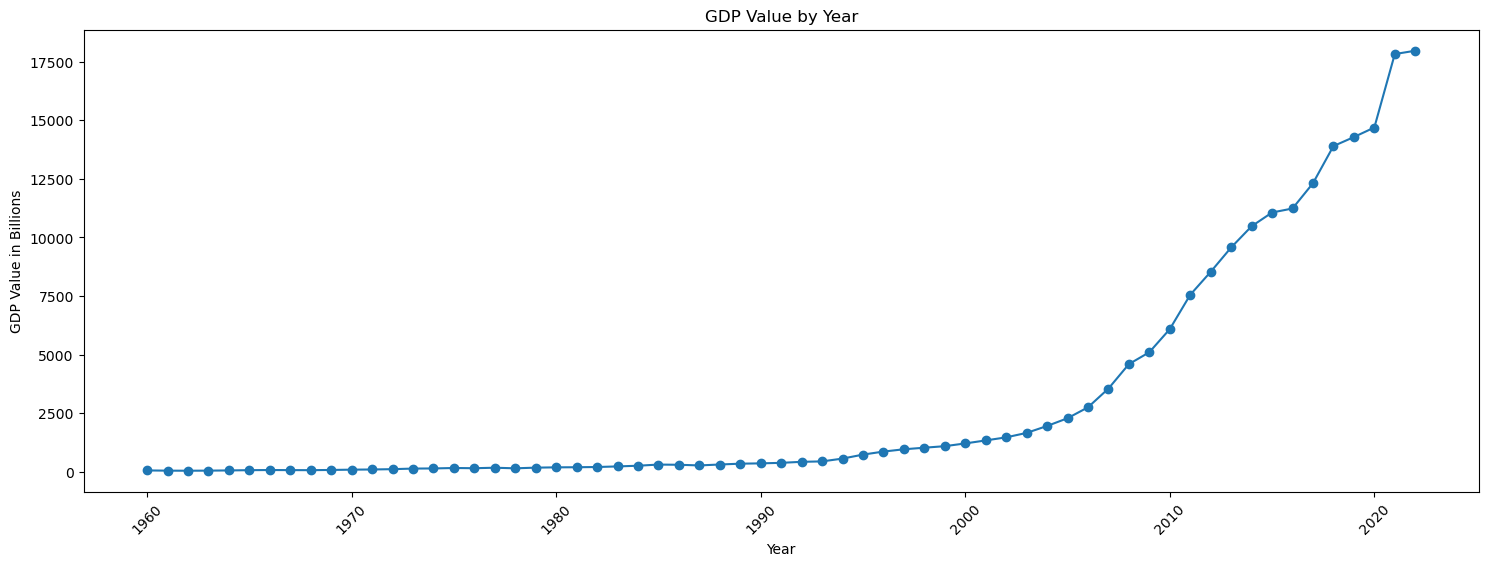

In [11]:
df = df.sort_values(by='date')

# Create a plot of 'value' by 'date'
plt.figure(figsize=(18, 6))  # Set the figure size
plt.plot(df['date'], df['value_billions'], marker='o')  # Plot 'value' against 'date'

# Add titles and labels
plt.title('GDP Value by Year')
plt.xlabel('Year')
plt.ylabel('GDP Value in Billions')

plt.xticks(rotation=45)  # Rotate the labels by 45 degrees

# Show the plot
plt.show()

In [12]:
gdp_date_corr = df['value'].corr(df['date'])

print("Correltion of year with value of GDP: ", gdp_date_corr )

Correltion of year with value of GDP:  0.7849067828389961


<Axes: ylabel='Frequency'>

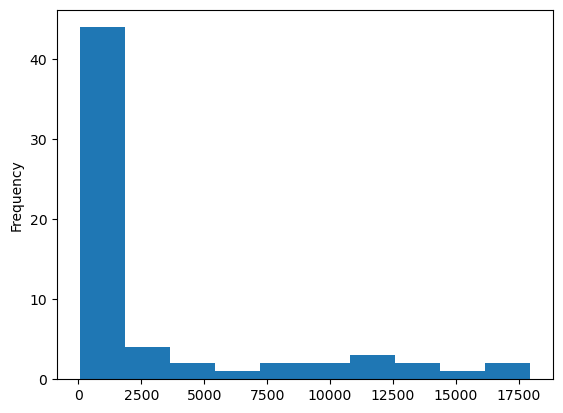

In [13]:
df['value_billions'].plot(kind='hist')

Since initial dataset does not have a lot of information except value of GDP I will merge it with data from other sources.

In [14]:
#adding new dataset to extract inflation as new feature

filename = 'Countries_inflation1960-2021.csv'

df_inflation = pd.read_csv(filename)

#filter data set only for China inflation info

china_inflation_df = df_inflation[df_inflation['Country Name'] == 'China']

china_inflation_df.head()


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
40,China,CHN,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,2.619524,2.62105,1.921642,1.437024,2.000002,1.593136,2.07479,2.899234,2.419422,0.981015


Merging newly made column with existing df


In [15]:
#rename 'date' column in df to year for consistency
df = df.rename(columns = {'date': 'Year' })

#making sure year is in format int
df['Year'] = df['Year'].astype(int)


china_inflation_df = pd.DataFrame(china_inflation_df)
china_inflation_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
40,China,CHN,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,2.619524,2.62105,1.921642,1.437024,2.000002,1.593136,2.07479,2.899234,2.419422,0.981015


In [16]:
year_columns = china_inflation_df.columns[4:]

china_long_format = pd.melt(china_inflation_df, 
                            value_vars=year_columns, 
                            var_name='Year', 
                            value_name='inflation_rate')

china_long_format['Year'] = china_long_format['Year'].astype(int)

merged_df = pd.merge(df, china_long_format, on='Year')


Adding another dataset with information about export, import, household consumption, capital investment & government spending.

In [17]:
filename = 'china_economy_data.csv'

df_china_economy = pd.read_csv(filename)

df_china_economy.head()

,Country,Code,ContinentCode,Year,Capital investment billion USD,Household consumption billion USD,Exports of goods and services billion USD,Imports of goods and services billion USD,Government spending billion USD
0,China,CHN,AS,1960,23.64,30.13,2.57,2.64,7.43
1,China,CHN,AS,1961,11.42,33.17,1.94,1.75,7.16
2,China,CHN,AS,1962,7.43,34.07,1.91,1.37,5.99
3,China,CHN,AS,1963,11.03,34.29,2.03,1.45,6.86
4,China,CHN,AS,1964,14.54,36.14,2.25,1.71,7.57


In [18]:
df_china_economy['Year'] = df_china_economy['Year'].astype(int)
merged_df  = pd.merge(merged_df, df_china_economy, on='Year')

merged_df.head()

,countryiso3code,Year,value,unit,obs_status,decimal,indicator.id,indicator.value,country.id,country.value,value_billions,inflation_rate,Country,Code,ContinentCode,Capital investment billion USD,Household consumption billion USD,Exports of goods and services billion USD,Imports of goods and services billion USD,Government spending billion USD
0,CHN,1960,5.971625e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,59.716252,NaN,China,CHN,AS,23.64,30.13,2.57,2.64,7.43
1,CHN,1961,5.005669e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,50.056688,NaN,China,CHN,AS,11.42,33.17,1.94,1.75,7.16
2,CHN,1962,4.720919e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,47.209188,NaN,China,CHN,AS,7.43,34.07,1.91,1.37,5.99
3,CHN,1963,5.070662e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,50.706617,NaN,China,CHN,AS,11.03,34.29,2.03,1.45,6.86
4,CHN,1964,5.970813e+10,,,0,NY.GDP.MKTP.CD,GDP (current US$),CN,China,59.708128,NaN,China,CHN,AS,14.54,36.14,2.25,1.71,7.57


In [19]:
#dropping useless columns and value column, since all other info is in billions
columns_to_drop = ['value','countryiso3code', 'unit', 'obs_status', 'decimal', 'indicator.id', 'indicator.value', 'country.id', 'country.value', 'Country', 'Code', 'ContinentCode']
merged_df = merged_df.drop(columns=columns_to_drop, axis=1)

merged_df.head()

,Year,value_billions,inflation_rate,Capital investment billion USD,Household consumption billion USD,Exports of goods and services billion USD,Imports of goods and services billion USD,Government spending billion USD
0,1960,59.716252,NaN,23.64,30.13,2.57,2.64,7.43
1,1961,50.056688,NaN,11.42,33.17,1.94,1.75,7.16
2,1962,47.209188,NaN,7.43,34.07,1.91,1.37,5.99
3,1963,50.706617,NaN,11.03,34.29,2.03,1.45,6.86
4,1964,59.708128,NaN,14.54,36.14,2.25,1.71,7.57


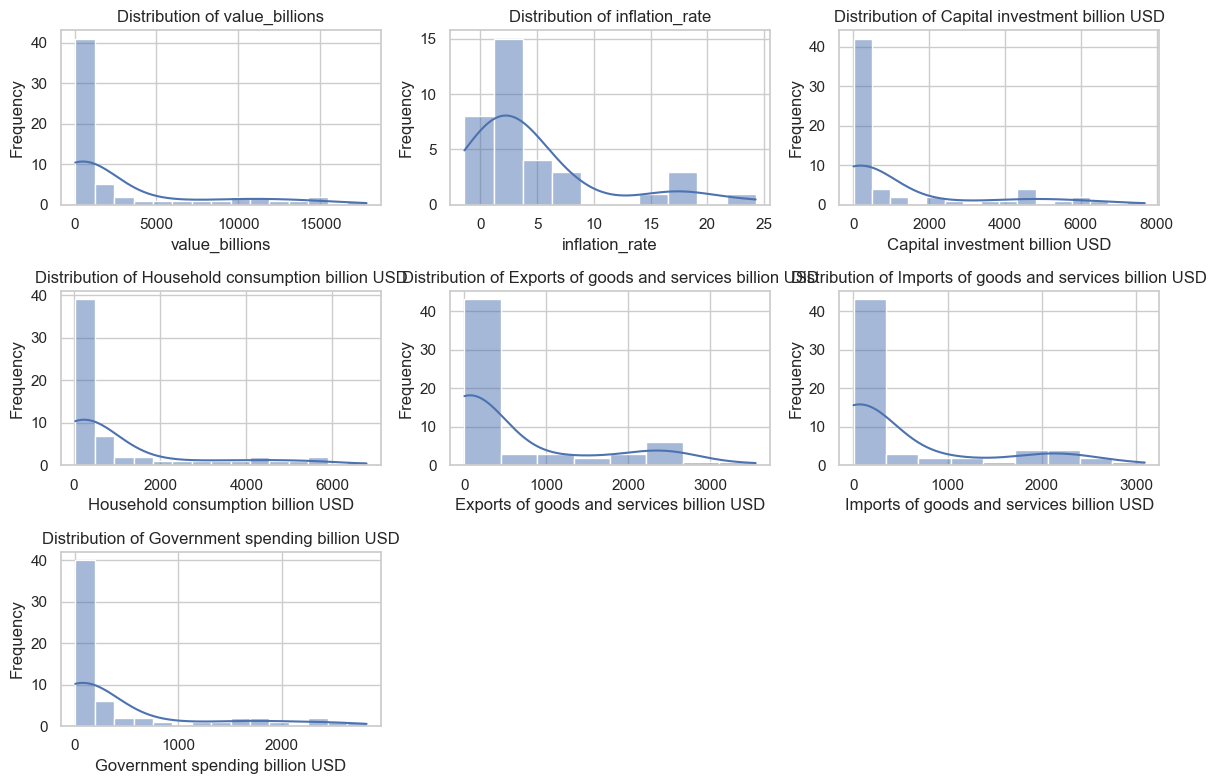

In [20]:
numeric_cols = merged_df.drop('Year', axis=1)

# Set plot style
sns.set(style="whitegrid")

# Calculate the number of rows and columns for subplots
num_cols = len(numeric_cols.columns)
num_rows = (num_cols + 2) // 3  # Adjust the number of rows as needed

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 8))

# Plot histograms for each numeric column
for i, col in enumerate(numeric_cols.columns):
    row = i // 3
    col_num = i % 3
    ax = axes[row, col_num]
    sns.histplot(merged_df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Remove any empty subplots
for i in range(num_cols, num_rows * 3):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


Our data does not follow normal distribution, so we will use MinMax Scaler instead of StandartScaler.

In [21]:
print(merged_df.shape)

merged_df.corr()

(62, 8)


,Year,value_billions,inflation_rate,Capital investment billion USD,Household consumption billion USD,Exports of goods and services billion USD,Imports of goods and services billion USD,Government spending billion USD
Year,1.000000,0.778624,-0.529803,0.774843,0.777444,0.812612,0.806580,0.769053
value_billions,0.778624,1.000000,-0.360871,0.999243,0.998999,0.983076,0.987202,0.999050
inflation_rate,-0.529803,-0.360871,1.000000,-0.354053,-0.361818,-0.387571,-0.379157,-0.357443
Capital investment billion USD,0.774843,0.999243,-0.354053,1.000000,0.996818,0.985477,0.990106,0.997654
Household consumption billion USD,0.777444,0.998999,-0.361818,0.996818,1.000000,0.975702,0.980760,0.999356
Exports of goods and services billion USD,0.812612,0.983076,-0.387571,0.985477,0.975702,1.000000,0.998116,0.975952
Imports of goods and services billion USD,0.806580,0.987202,-0.379157,0.990106,0.980760,0.998116,1.000000,0.981295
Government spending billion USD,0.769053,0.999050,-0.357443,0.997654,0.999356,0.975952,0.981295,1.000000


<Axes: >

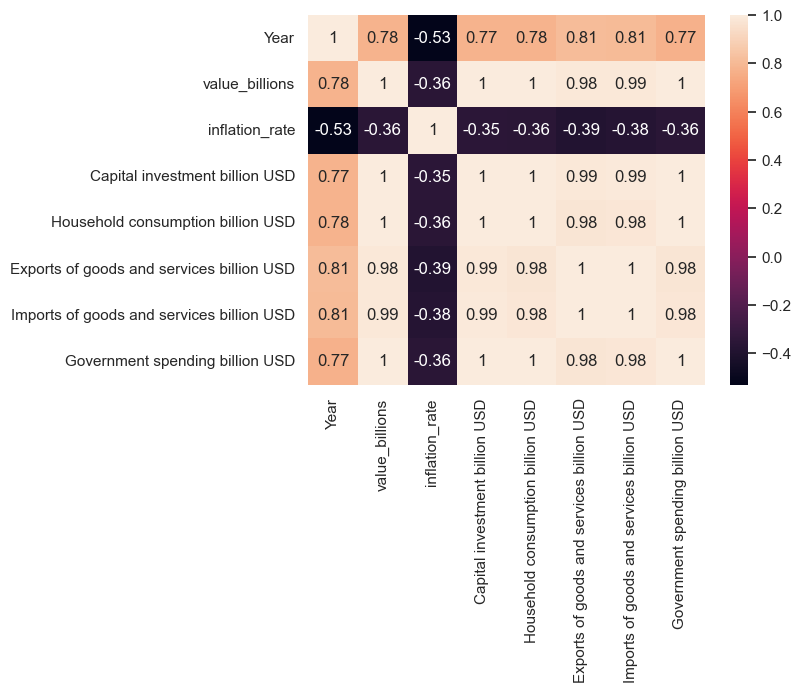

In [22]:
sns.heatmap(merged_df.corr(), annot=True)

Since many of these features are highly correlated with each other, using them all in a predictive model might lead to multicollinearity issues.We can try Principle Component Analysis to reduce dimensionality and retaining most of information.
However before that we need to clean the data:
 - Handle missing data
 - Normalize data
 - Check for any inconsistencies

In [23]:
merged_df.isnull().sum()

Year                                          0
value_billions                                0
inflation_rate                               27
Capital investment billion USD                0
Household consumption billion USD             0
Exports of goods and services billion USD     0
Imports of goods and services billion USD     0
Government spending billion USD               0
dtype: int64

The only columns with missing values is inflation rate. It is available only after year 1987.

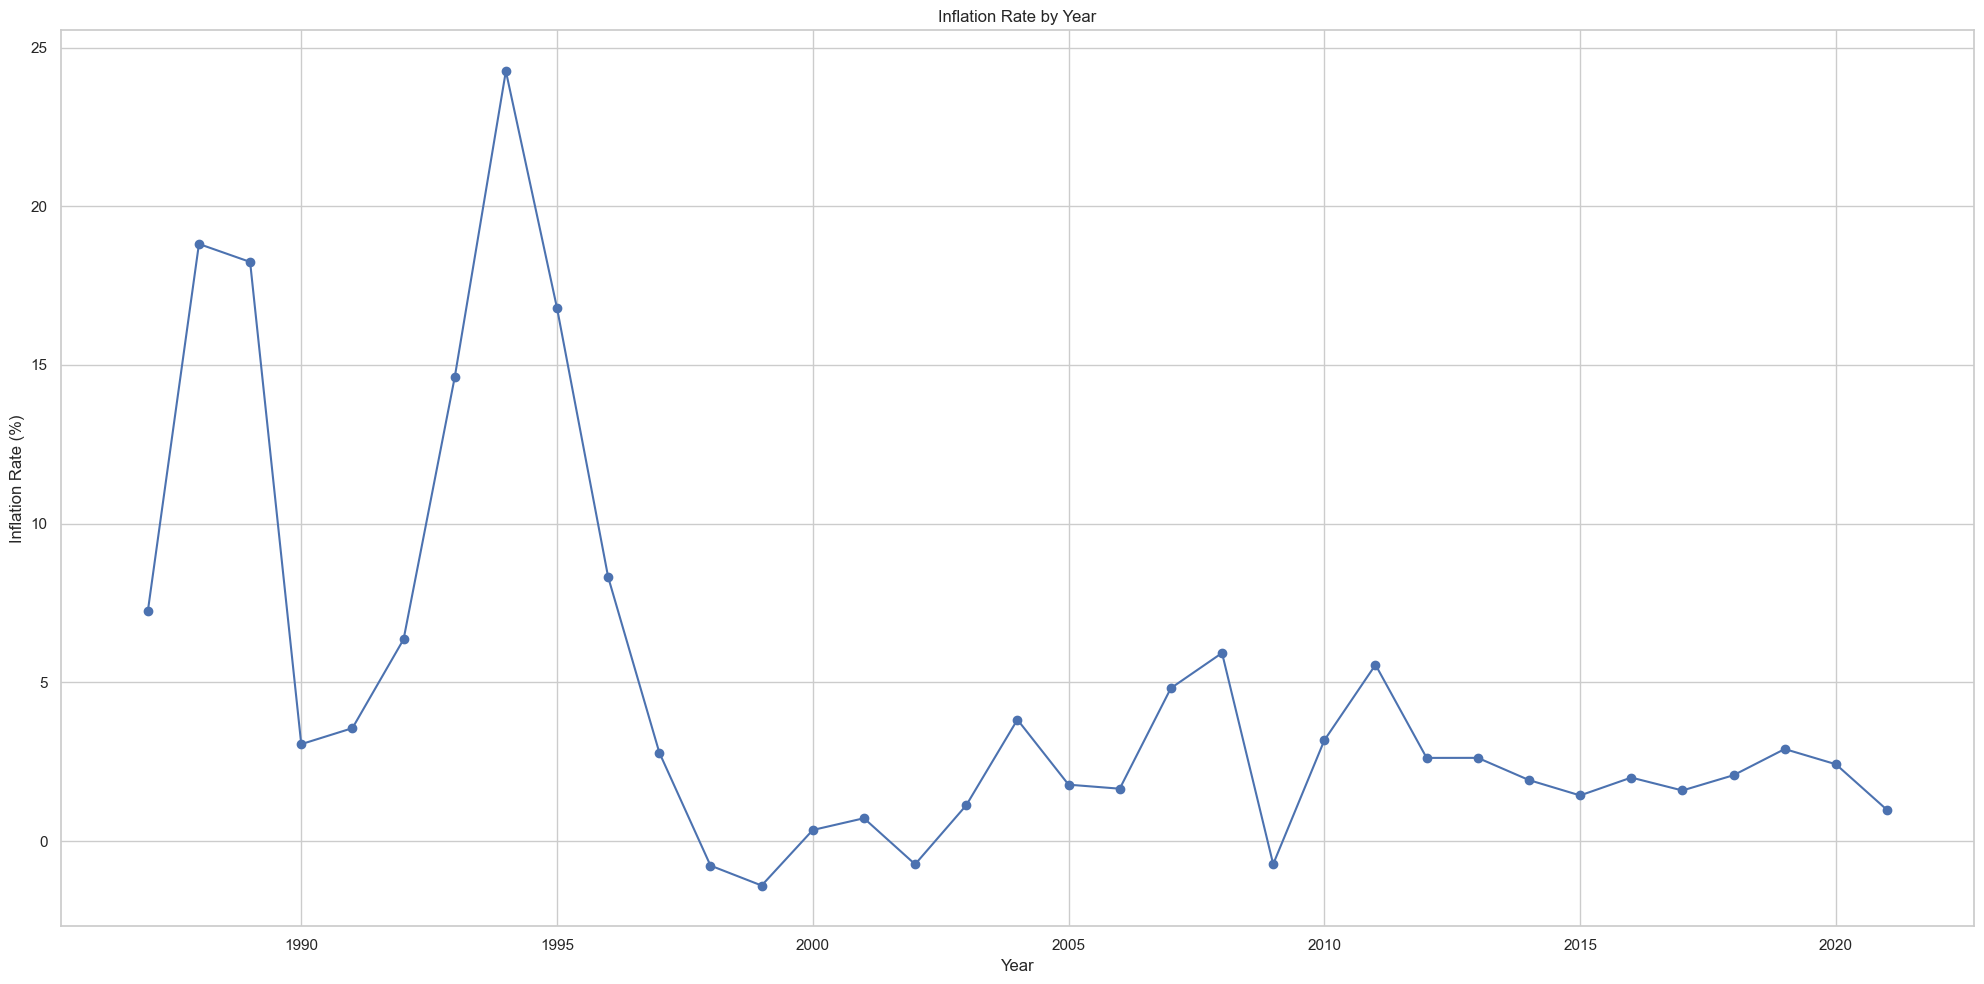

In [24]:
# Create a histogram
plt.figure(figsize=(20,10))
plt.plot(merged_df['Year'], merged_df['inflation_rate'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.title('Inflation Rate by Year')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
merged_df['inflation_rate'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: inflation_rate, dtype: float64

For imputation of missing values we will use ARIMA (AutoRegressive Integrated Moving Average) model which is typically used for predicting future points in a time series based on past data. However, it can also be adapted for imputation, where the goal is to fill in missing past data points even if those points are in the past.  This approach ensures that the imputed values are not just random fill-ins but are informed by the inherent patterns and trends in data.

In [26]:
#making a times series of inflation for future imputation

years = merged_df['Year'].tolist()
inflation_data = merged_df.set_index('Year')['inflation_rate']

# Create a Series
inflation_data = pd.Series(inflation_data)

# Display the Series
print(inflation_data)

Year
1960         NaN
1961         NaN
1962         NaN
1963         NaN
1964         NaN
          ...   
2017    1.593136
2018    2.074790
2019    2.899234
2020    2.419422
2021    0.981015
Name: inflation_rate, Length: 62, dtype: float64


In [43]:
inflation_data.index = pd.to_datetime(inflation_data.index, format='%Y') #need format of yyyy-mm-dd

#apparently ARIMA doesnt work when values are missing, so have to fill as the first step (weird)
inflation_filled = inflation_data.fillna(inflation_data.median())
#inflation_filled = inflation_data.fillna(inflation_data.mean())
#inflation_filled = inflation_data.fillna(0)


# Use auto_arima to find the best ARIMA model
#auto_model = auto_arima(inflation_filled, seasonal=False, m=1, trace=True, error_action='ignore', suppress_warnings=True)
#best_order = auto_model.order #after several runs 101 fits the best

# Fit the ARIMA model
arima_model = ARIMA(inflation_filled, order=(2,0,1))
arima_fitted = arima_model.fit()

# Predict the missing values for the years 1960-1986
predicted_values = arima_fitted.predict(start=pd.to_datetime('1960'), end=pd.to_datetime('1986'))

# Replace the missing values in your original series
inflation_data.update(predicted_values)


#parametr 201 works the best

/Users/admin/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [44]:
# Assuming 'Year' is a column in merged_df
# Convert 'Year' in merged_df to datetime for alignment
merged_df['Year'] = pd.to_datetime(merged_df['Year'], format='%Y')

# Set 'Year' as index if it's not already
merged_df.set_index('Year', inplace=True)

# Update the 'inflation_rate' column in merged_df with the values from inflation_data
merged_df['inflation_rate'] = inflation_data

# Reset the index if you want 'Year' back as a column
merged_df.reset_index(inplace=True)


merged_df.head()

,Year,value_billions,inflation_rate,Capital investment billion USD,Household consumption billion USD,Exports of goods and services billion USD,Imports of goods and services billion USD,Government spending billion USD
0,1960-01-01,0.000704,4.123835,0.002111,0.000000,0.000186,0.000411,0.000512
1,1961-01-01,0.000160,4.042061,0.000520,0.000450,0.000008,0.000123,0.000416
2,1962-01-01,0.000000,3.914902,0.000000,0.000583,0.000000,0.000000,0.000000
3,1963-01-01,0.000197,3.169633,0.000469,0.000615,0.000034,0.000026,0.000309
4,1964-01-01,0.000703,4.307406,0.000926,0.000889,0.000096,0.000110,0.000562


In [45]:
inflation_data.head(27)

Year
1960-01-01    4.123835
1961-01-01    4.042061
1962-01-01    3.914902
1963-01-01    3.169633
1964-01-01    4.307406
1965-01-01    2.838777
1966-01-01    4.483406
1967-01-01    2.726251
1968-01-01    4.511579
1969-01-01    2.744764
1970-01-01    4.446831
1971-01-01    2.835726
1972-01-01    4.334865
1973-01-01    2.957435
1974-01-01    4.208034
1975-01-01    3.083322
1976-01-01    4.085940
1977-01-01    3.198726
1978-01-01    3.978503
1979-01-01    3.297164
1980-01-01    3.889285
1981-01-01    3.377151
1982-01-01    3.818160
1983-01-01    3.439896
1984-01-01    3.763160
1985-01-01    3.487814
1986-01-01    3.721625
Name: inflation_rate, dtype: float64

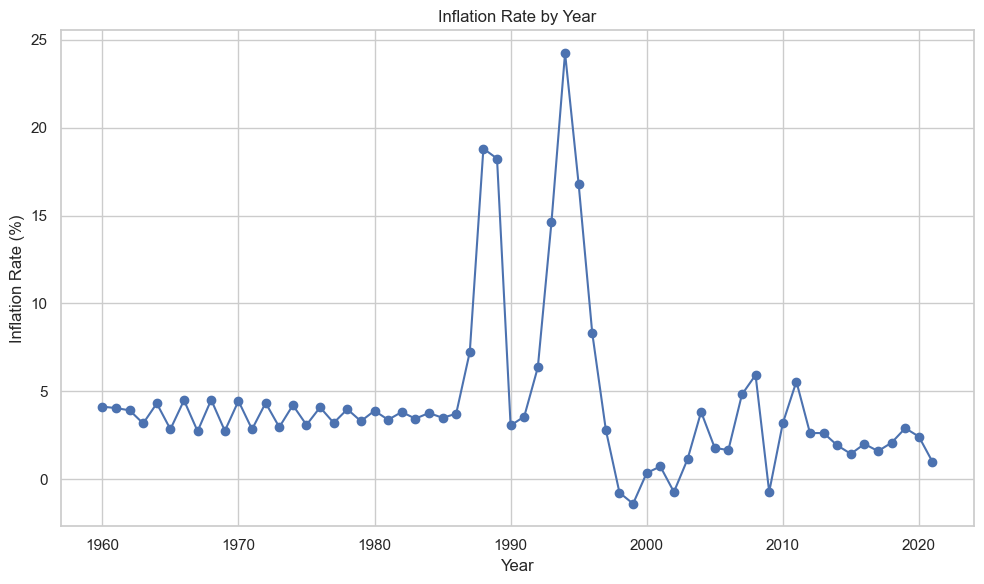

In [46]:
#see the result of imputation
years = inflation_data.index  # Get the years for the x-axis
inflation_rates = inflation_data.values  # Get the inflation rates for the y-axis

plt.figure(figsize=(10, 6))
plt.plot(years, inflation_rates, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.title('Inflation Rate by Year')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

Conclusion: So for this to work missing values at first needs to be imputed with something. Imputation with median, creates a straight line. Imputation with 0, gets a zig zag line but not as much, and looks like a straight line as well. Imputing with mean works the best, assuming that it is how imputing with ARIMA suppose to work. Considering the amount of time that it took to set this imputation, I would probably drop the values next time

Normalizing all dat to be on the same scale, except for Year column.

In [47]:
# Normalize data
years = merged_df['Year']
merged_df_without_year = merged_df.drop('Year', axis=1)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the data
normalized_data = scaler.fit_transform(merged_df_without_year)

# Create a new DataFrame with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=merged_df_without_year.columns)

# Add the 'Year' column back to the normalized DataFrame
normalized_df['Year'] = years.values

# Rename normalized_df to merged_df
merged_df = normalized_df

# Now, merged_df contains all columns normalized, with 'Year' as a column
merged_df.head()

,value_billions,inflation_rate,Capital investment billion USD,Household consumption billion USD,Exports of goods and services billion USD,Imports of goods and services billion USD,Government spending billion USD,Year
0,0.000704,0.215341,0.002111,0.000000,0.000186,0.000411,0.000512,1960-01-01
1,0.000160,0.212154,0.000520,0.000450,0.000008,0.000123,0.000416,1961-01-01
2,0.000000,0.207198,0.000000,0.000583,0.000000,0.000000,0.000000,1962-01-01
3,0.000197,0.178152,0.000469,0.000615,0.000034,0.000026,0.000309,1963-01-01
4,0.000703,0.222495,0.000926,0.000889,0.000096,0.000110,0.000562,1964-01-01


In [48]:
#Change date object back to int
merged_df['Year'] = merged_df['Year'].dt.year

In [49]:
from sklearn.decomposition import PCA

# Apply PCA to the normalized data (excluding 'Year')
pca = PCA(n_components=3)  # Adjust the number of components as needed
pca_data = pca.fit_transform(normalized_df.drop('Year', axis=1))

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(data=pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])



# Add the 'Year' column back (optional, if needed)
pca_df['Year'] = merged_df['Year']
pca_df['Label'] = merged_df['value_billions']

# Now, pca_df contains the principal components and 'Year'
pca_df.head()

,PC1,PC2,PC3,Year,Label
0,-0.395764,-0.036997,-0.012009,1960,0.000704
1,-0.396449,-0.040256,-0.012084,1961,0.000160
2,-0.396533,-0.045237,-0.011990,1962,0.000000
3,-0.393977,-0.074163,-0.012592,1963,0.000197
4,-0.396564,-0.029891,-0.012312,1964,0.000703


Tried to run DT with PCA and without. 

In [50]:
"""y= merged_df['value_billions']
X = merged_df.drop(columns='value_billions', axis = 1)

print("Number of examples: " + str(X.shape[0]))
print("\nNumber of Features:" + str(X.shape[1]))
print(str(list(X.columns)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=123)
print('\nTraining Set: ', X_train.shape)
print('Testing Set: ', X_test.shape)"""


y= pca_df['Label']
X = pca_df.drop(columns='Label', axis = 1)

print("Number of examples: " + str(X.shape[0]))
print("\nNumber of Features:" + str(X.shape[1]))
print(str(list(X.columns)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=123)
print('\nTraining Set: ', X_train.shape)
print('Testing Set: ', X_test.shape)



Number of examples: 62

Number of Features:4
['PC1', 'PC2', 'PC3', 'Year']

Training Set:  (43, 4)
Testing Set:  (19, 4)


In [52]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, None],  # None means no maximum depth limit
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}

# Create a base model
dt = DecisionTreeRegressor()

# Create a scorer for mean squared error
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize the grid search model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           scoring=mse_scorer, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Best estimator
best_estimator = grid_search.best_estimator_

# Evaluate the best model
predictions = best_estimator.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error of the best model: {mse}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=4; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=4; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=4; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=6; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=6; total time

In [54]:

from sklearn.metrics import mean_squared_error, r2_score

def train_test_DT_regression(X_train, X_test, y_train, y_test, leaf, depth, crit):
    """
    Parameters:
        leaf := The minimum number of samples required to be at a leaf node 
        depth := The maximum depth of the tree
        crit := The function to be used to measure the quality of a split.
    """
    # Create the DecisionTreeRegressor model object with specified parameters
    model = DecisionTreeRegressor(criterion=crit, max_depth=depth, min_samples_leaf=leaf)

    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    predictions = model.predict(X_test)

    # Compute the Mean Squared Error
    mse_score = mean_squared_error(y_test, predictions)

    # Compute the Root Mean Squared Error
    rmse_score = mean_squared_error(y_test, predictions, squared=False)

    # Compute the R-squared score
    r2_score_value = r2_score(y_test, predictions)
    
    return mse_score, rmse_score, r2_score_value


best_params = grid_search.best_params_

# Call the function with the best parameters from the grid search
mse, rmse, r2 = train_test_DT_regression(
    X_train, X_test, y_train, y_test, 
    leaf=best_params['min_samples_leaf'], 
    depth=best_params['max_depth'], 
    crit=best_params['criterion']
)

print(f'Best Model - MSE: {mse}, RMSE: {rmse}, R-squared: {r2}')




Best Model - MSE: 0.012355862048491838, RMSE: 0.1111569253285275, R-squared: 0.758390824766714


The MSE and RMSE are relatively low, suggesting good accuracy, and the R-squared value is reasonably high, indicating a good fit to the data. 
R2 is 0.75 which suggests that 75.84% of the variance in the target is explained by the model.